This script prepares a geodataframe from IDF spreadsheet files. The geodataframe can be exported as a shapefile and used for applications such as estimating  gridded rainfall parameters.

You need to download [IDF data](https://drive.google.com/drive/folders/1VsJnWGfz2NTzT4orgTH1RL3yzZcrdYTC) from the Government of Canada here.

Code style is probably terrible, I'm new to Python.

In [20]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re #for regexp

def get_idf_sdf(folder_path):
    # setup dataframe
    df = pd.DataFrame(
            {"STATION_ID":[],
             "PROV":[],
             "STATION_NAME":[],
             "LATITUDE":[],
            "LONGITUDE":[],
            "ELEVATION":[],
            "A_COEFF":[],
            "B_COEFF":[]}
            )
    # iterate through each province
    for prov in ["AB","BC","MB","NB","NL","NS","NT","NU","ON","PE","QC","SK","YT"]:
        folder_path_prov = folder_path + "IDF_v3.10_2020_03_27_" + prov + "\\"
        
        # iterate through each file in folder
        for f in os.listdir(folder_path_prov):
            
            # identify each data file (might need to adapt but working so far
            if f.endswith(".txt") & f.startswith("idf"):
                
                file_path = folder_path_prov + f
                
                # iterate through lines of file, grabbing ID, location, and IDF coefficients...
                # this code makes A LOT of assumptions about the file structure (i.e., what line the name is on, etc. as opposed to searching for keywords)
                #unless it changes between provinces should work for the timebeing...
                
                # open the file
                file_data = open(file_path,"r")
                data = list()
                line_data = 99999

                for line_num, line in enumerate(file_data):
                    
                    #grab the station name and id
                    if line_num == 13:
                        station_data = line
                        x = station_data.split()
                        idx = x.index(prov)
                        station_name = " ".join(x[:idx])
                        station_id = "_".join(x[(idx+1):]);
                        
                    # grad the lat/lon/elev data
                    if line_num == 15:
                        location_data = line
                        x = location_data.split()
                        
                        # remove non-numeric characters, convert to degrees
                        lat = float(re.sub('[^0-9]','',x[1])) + float(re.sub('[^0-9]','',x[2]))/60
                        lon = float(re.sub('[^0-9]','',x[4])) + float(re.sub('[^0-9]','',x[5]))/60
                        elev = float(x[7])
                    
                    # get the line number for table 3
                    if "Table 3 : Interpolation Equation / Équation d'interpolation: R = A*T^B" in line:
                        line_table3 = line_num
                        line_data = line_table3 + 10
                    
                    # store the table 3 data
                    if line_num >= line_data:
                        data.append(line.strip())
                        
                # grab the a and b coefficients from the table 3 data
                for row in data:
                    x = row.split()
                    if "Coefficient (A)" in row:
                        x = row.split()
                        a_coeffs = list(map(float,(x[(len(x) - 6):len(x)])))
                    elif "Exponent/Exposant (B)" in row:
                        b_coeffs = list(map(float,(x[(len(x) - 6):len(x)])))

                # store data in dataframe
                df = df.append({
                        "STATION_NAME":station_name, 
                        "STATION_ID":station_id,
                        "PROV":prov,
                        "LATITUDE":lat, 
                        "LONGITUDE":lon, 
                        "ELEVATION":elev,
                        "A_COEFF":a_coeffs, 
                        "B_COEFF":b_coeffs},
                        ignore_index=True)


    # change A and B lists into seperate columns in dataframe - can't export 'list' datatype to shapefile...
    return_periods = [2,5,10,25,50,100]
    A_COEFF_COLNAMES = list()
    B_COEFF_COLNAMES = list()

    for x in return_periods:
        A_COEFF_COLNAMES.append('A_'+str(x))
        B_COEFF_COLNAMES.append('B_'+str(x))
    
    df2 = df.copy()
    df2[A_COEFF_COLNAMES] = pd.DataFrame(df2.A_COEFF.values.tolist(), index = df2.index)
    df2[B_COEFF_COLNAMES] = pd.DataFrame(df2.B_COEFF.values.tolist(), index = df2.index)
    df2=df2.drop(columns=["A_COEFF","B_COEFF"])
    return df2


In [1]:
folder_path = r"\IDF-20200331T182605Z-001\IDF\idf_v3-10_2020_03_27_preliminary\IDF_Files_Fishiers"

df = get_idf_sdf(folder_path)
print(df.head())
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(-df.LONGITUDE, df.LATITUDE))

  STATION_ID PROV               STATION_NAME   LATITUDE   LONGITUDE  \
0    3011240   AB                    CAMROSE  53.050000  112.816667   
1    3011887   AB         CORONATION CLIMATE  52.066667  111.450000   
2    3012206   AB  EDMONTON INTERNATIONAL CS  53.316667  113.616667   
3    3012209   AB        EDMONTON BLATCHFORD  53.566667  113.516667   
4    3012210   AB           EDMONTON NAMAO A  53.666667  113.466667   

   ELEVATION   A_2   A_5  A_10  A_25  A_50  A_100    B_2    B_5   B_10   B_25  \
0      739.0  13.1  18.6  22.3  27.0  30.4   33.8 -0.685 -0.691 -0.693 -0.695   
1      791.0  13.5  18.1  21.2  25.0  27.9   30.7 -0.689 -0.680 -0.677 -0.673   
2      715.0  14.8  20.5  24.2  28.9  32.4   35.9 -0.660 -0.674 -0.680 -0.685   
3      671.0  15.4  22.7  27.5  33.6  38.1   42.6 -0.659 -0.664 -0.666 -0.668   
4      687.0  15.8  22.0  26.1  31.3  35.1   38.9 -0.651 -0.659 -0.663 -0.666   

    B_50  B_100  
0 -0.696 -0.697  
1 -0.671 -0.670  
2 -0.688 -0.691  
3 -0.669 -0.66

(39.95, 56.983333333333334)

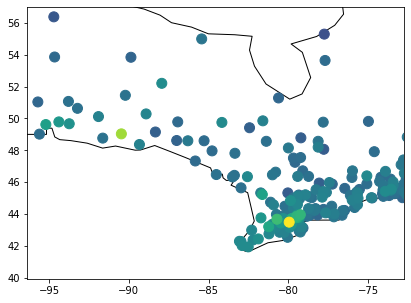

In [74]:
# load basemap of canada
fig, ax = plt.subplots(figsize=(10,5))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.name == 'Canada'].plot(
    ax=ax,color='white', edgecolor='black')

# calculate rainfall intensity from IDF coefficients
gdf["i_50"] = gdf.A_50 * 0.5 ** gdf.B_50
gdf.sort_values(by="i_50", inplace=True)
gdf.plot(ax=ax, column="i_50", markersize = 100)
gdf.to_file(filename="idf_coeffs_canada.shp",driver="ESRI Shapefile")

# change map limits to zoom into stations located in a given province
buff=2
prov = "ON"
ax.set_xlim(gdf[gdf.PROV == prov].buffer(buff).unary_union.bounds[0],gdf[gdf.PROV == prov].buffer(buff).unary_union.bounds[2])
ax.set_ylim(gdf[gdf.PROV == prov].buffer(buff).unary_union.bounds[1],gdf[gdf.PROV == prov].buffer(buff).unary_union.bounds[3])